In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras

TensorFlow version: 2.9.1


In [2]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import pickle
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
from sklearn.preprocessing import Normalizer

## Loading a dataset

## Split into train data and test data as dataset
- データセットとして使用するデータを取得する。
- trainデータとtestデータに分割する。（例えば80%をtrainデータに、20%をtestデータに、など。）
- 書き方はデータセットとして使用するデータの type による。もし、numpy の形で持っているならhttps://www.tensorflow.org/tutorials/load_data/numpy?hl=ja が参考になります。

In [3]:


# x_path = '../../data/npy/x_random_l1_6.npy'
x_path = '../../data/npy/x_random_l2_6_dv.npy'
# x_path = '../../data/npy/x_random_6_diffseq_mean_l1.npy'
# x_path = '../../data/npy/x_random_6_diffseq_mean_l1_3.npy'
x_data = np.load(x_path)

# y_path = '../../data/npy/y_random_l1_6.npy'
y_path = '../../data/npy/y_random_l2_6_dv.npy'
# y_path = '../../data/npy/y_random_6_diffseq_mean_l1.npy'
# y_path = '../../data/npy/y_random_6_diffseq_mean_l1_3.npy'
y_data = np.load(y_path, allow_pickle=True)



print(len(y_data))

# min_val = y_data.min()
# max_val = y_data.max()

# y_data = (y_data - min_val)/(max_val - min_val)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

1500
(1200, 256)
(300, 256)
(1200,)
(300,)


## Set my model
- input_shape は入力データのサイズ。
- モデルの定義方法は調べればたくさん出てきますが、例えばここ： https://sinyblog.com/deaplearning/keras_how_to/ 
- 最後の層の出力は、期待する出力データのサイズ
- [model](https://github.com/si-tm/docs-l10n/blob/master/site/ja/tutorials/quickstart/beginner.py)

In [4]:
def build_model():
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'), # units=128 : 出力空間の次元数
    tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    tf.keras.layers.Dense(1) 
    ])

    optimizer = tf.keras.optimizers.Adam() # optimizers も Adam 以外に色々種類があります。調べてみてください！

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # loss 関数に何を採用するかはどんな問題を解きたいのかによります。
                                        #ここでは MSE を採用していますが、他にも色々な選択肢があります。調べてみてください！
    return model

In [5]:
model = build_model()

2023-02-15 10:58:08.551467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,025
Trainable params: 33,025
Non-trainable params: 0
_________________________________________________________________


In [7]:
example_batch = x_train[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
# example_result

(10, 256)
1/1 [==============================] - 0s 444ms/step


In [8]:
print(example_result)

[[ 0.1765241 ]
 [ 0.123049  ]
 [-0.0026357 ]
 [ 0.15715654]
 [ 0.03182069]
 [ 0.2373571 ]
 [ 0.01324304]
 [ 0.10650447]
 [-0.03607529]
 [ 0.20663698]]


In [9]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 400 # epoch 数も考慮しよう
# EPOCHS = 100 # epoch 数も考慮しよう

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
395,0.491460,0.545465,0.491460,0.230676,0.370592,0.230676,395
396,0.467979,0.533105,0.467979,0.284229,0.410266,0.284229,396
397,0.461224,0.525279,0.461224,0.281997,0.406199,0.281997,397
398,0.467597,0.533514,0.467597,0.255575,0.385813,0.255575,398
399,0.499398,0.544606,0.499398,0.232368,0.373063,0.232368,399


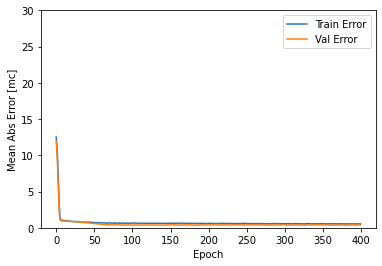

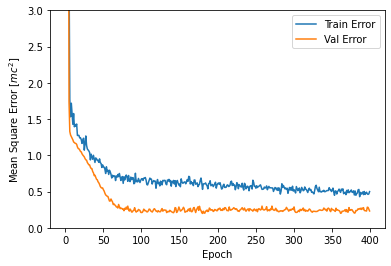

In [11]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mc]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$mc^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

10/10 [==============================] - 0s 5ms/step


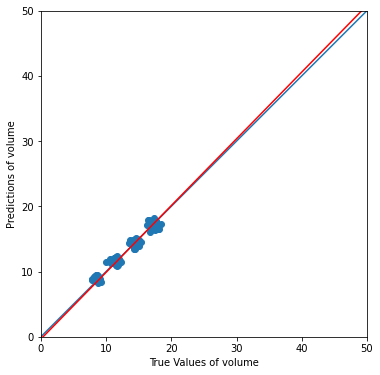

In [14]:
test_predictions = model.predict(x_test).flatten()
res = linregress(test_predictions, y_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
# plt.xlabel('True Values [mc]')
# plt.ylabel('Predictions [mc]')
plt.xlabel('True Values of volume')
plt.ylabel('Predictions of volume')
plt.axis('equal')
plt.axis('square')
# plt.xlim([-0.5,1])
# plt.ylim([-0.5,1])
# _ = plt.plot([-0.5, 1], [-0.5, 1])
plt.xlim([0,50])
plt.ylim([0,50])
_ = plt.plot([0,50], [0,50])

# plt.plot([-0.5, 1], res.intercept + res.slope*np.array([-0.5, 1]), 'r', label='fitted line')
plt.plot([0,50], res.intercept + res.slope*np.array([0, 50]), 'r', label='fitted line')

# normalizer 学習前

38/38 [==============================] - 0s 8ms/step


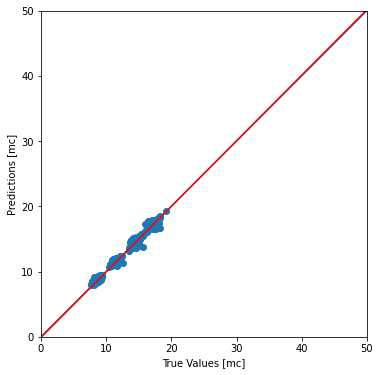

In [16]:
train_predictions = model.predict(x_train).flatten()
res = linregress(train_predictions, y_train)

plt.figure(figsize=(6,6))
plt.scatter(y_train, train_predictions)
plt.xlabel('True Values [mc]')
plt.ylabel('Predictions [mc]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,50])
plt.ylim([0,50])
_ = plt.plot([0,50], [0,50])

# plt.plot([-0.5, 1], res.intercept + res.slope*np.array([-0.5, 1]), 'r', label='fitted line')
plt.plot([0,50], res.intercept + res.slope*np.array([0, 50]), 'r', label='fitted line')


In [17]:
# トレーニングした model をどこかで使用したいなら以下のようにモデルを保存する
# model.save('../saved_model/random_l1_6_not_mean_model')

In [18]:
mse = tf.keras.losses.MeanSquaredError()

In [19]:
mse(y_test,test_predictions).numpy()

0.25408635

In [ ]:
test_predictions.rank

In [ ]:
test_predictions

In [ ]:
type(y_test)